# San Francisco Fire Calls

This notebook is the end-to-end example from Chapter 3, from Learning Spark 2nEd showing how to use DataFrame and Spark SQL for common data analytics patterns and operations on a San Francisco Fire Department Calls dataset. It also demonstrates how to ETL, examine and query data for analysis. Additionally, it shows how to save in-memory Spark DataFrames as parquet files and read them back as a Spark supported Parquet data source.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("MyPySparkApp").master("local[*]").getOrCreate()

Define our schema as the file has 4 million records. Inferring the schema is expensive for large files.

In [2]:
# Programmatic way to define a schema 
fire_schema = StructType([StructField('CallNumber', IntegerType(), True),
                StructField('UnitID', StringType(), True),
                StructField('IncidentNumber', IntegerType(), True),
                StructField('CallType', StringType(), True),                  
                StructField('CallDate', StringType(), True),      
                StructField('WatchDate', StringType(), True),
                StructField('ReceivedDtTm', StringType(), True),
                StructField('EntryDtTm', StringType(), True),
                StructField('DispatchDtTm', StringType(), True),
                StructField('ResponseDtTm', StringType(), True),
                StructField('OnSceneDtTm', StringType(), True),
                StructField('TransportDtTm', StringType(), True),
                StructField('HospitalDtTm', StringType(), True),
                StructField('CallFinalDisposition', StringType(), True),
                StructField('AvailableDtTm', StringType(), True),
                StructField('Address', StringType(), True),       
                StructField('City', StringType(), True),       
                StructField('Zipcode', IntegerType(), True),       
                StructField('Battalion', StringType(), True),                 
                StructField('StationArea', StringType(), True),       
                StructField('Box', StringType(), True),       
                StructField('OriginalPriority', StringType(), True),       
                StructField('Priority', StringType(), True),       
                StructField('FinalPriority', IntegerType(), True),       
                StructField('ALSUnit', BooleanType(), True),       
                StructField('CallTypeGroup', StringType(), True),
                StructField('NumAlarms', IntegerType(), True),
                StructField('UnitType', StringType(), True),
                StructField('UnitSequenceInCallDispatch', IntegerType(), True),
                StructField('FirePreventionDistrict', StringType(), True),
                StructField('SupervisorDistrict', StringType(), True),
                StructField('Neighborhood', StringType(), True),
                StructField('Location', StringType(), True),
                StructField('RowID', StringType(), True),
                StructField('Delay', FloatType(), True)]) #I haven't found this dataset

In [3]:
# Use the DataFrameReader interface to read a CSV file
sf_fire_file = "/opt/workspace/media/sf-fire-calls.csv"
fire_df = spark.read.csv(sf_fire_file, header=True, schema=fire_schema)

Cache the DataFrame since we will be performing some operations on it.

In [ ]:
#fire_df.cache() <- this function makes the following crash

DataFrame[CallNumber: int, UnitID: string, IncidentNumber: int, CallType: string, CallDate: string, WatchDate: string, ReceivedDtTm: string, EntryDtTm: string, DispatchDtTm: string, ResponseDtTm: string, OnSceneDtTm: string, TransportDtTm: string, HospitalDtTm: string, CallFinalDisposition: string, AvailableDtTm: string, Address: string, City: string, Zipcode: int, Battalion: string, StationArea: string, Box: string, OriginalPriority: string, Priority: string, FinalPriority: int, ALSUnit: boolean, CallTypeGroup: string, NumAlarms: int, UnitType: string, UnitSequenceInCallDispatch: int, FirePreventionDistrict: string, SupervisorDistrict: string, Neighborhood: string, Location: string, RowID: string, Delay: float]

In [4]:
fire_df.count()

4823917

In [5]:
fire_df.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- ReceivedDtTm: string (nullable = true)
 |-- EntryDtTm: string (nullable = true)
 |-- DispatchDtTm: string (nullable = true)
 |-- ResponseDtTm: string (nullable = true)
 |-- OnSceneDtTm: string (nullable = true)
 |-- TransportDtTm: string (nullable = true)
 |-- HospitalDtTm: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: in

In [6]:
fire_df.show(5, truncate=False)

+----------+------+--------------+----------------+----------+----------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------+----------------------+----------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+------------+--------------------------+----------------------+------------------+------------------------------+-------------------------------------+-------------+-----+
|CallNumber|UnitID|IncidentNumber|CallType        |CallDate  |WatchDate |ReceivedDtTm          |EntryDtTm             |DispatchDtTm          |ResponseDtTm          |OnSceneDtTm           |TransportDtTm         |HospitalDtTm          |CallFinalDisposition|AvailableDtTm         |Address               |City|Zipcode|Battalion|StationArea|Box |OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|Un

Filter out "Medical Incident" call types

Note that filter() and where() methods on the DataFrame are similar. Check relevant documentation for their respective argument types.

In [7]:
#from pyspark.sql.functions import col
few_fire_df = (fire_df
  .select("IncidentNumber", "AvailableDtTm", "CallType") 
  .where(col("CallType") != "Medical Incident"))

few_fire_df.show(5, truncate=False)

+--------------+----------------------+-----------------------------+
|IncidentNumber|AvailableDtTm         |CallType                     |
+--------------+----------------------+-----------------------------+
|30615         |04/12/2000 09:24:19 PM|Alarms                       |
|30620         |04/12/2000 09:44:28 PM|Citizen Assist / Service Call|
|30624         |04/12/2000 09:39:36 PM|Electrical Hazard            |
|30626         |04/12/2000 09:38:24 PM|Odor (Strange / Unknown)     |
|30627         |04/12/2000 09:50:48 PM|Alarms                       |
+--------------+----------------------+-----------------------------+
only showing top 5 rows



#### Q-1) How many distinct types of calls were made to the Fire Department?

To be sure, let's not count "null" strings in that column.

In [8]:
fire_df.select("CallType").where(col("CallType").isNotNull()).distinct().count()

32

#### Q-2) What are distinct types of calls were made to the Fire Department?

These are all the distinct type of call to the SF Fire Department

In [10]:
fire_df.select("CallType").where(col("CallType").isNotNull()).distinct().show(10, False)

+-----------------------------+
|CallType                     |
+-----------------------------+
|Elevator / Escalator Rescue  |
|Aircraft Emergency           |
|Alarms                       |
|Odor (Strange / Unknown)     |
|Citizen Assist / Service Call|
|HazMat                       |
|Oil Spill                    |
|Vehicle Fire                 |
|Suspicious Package           |
|Other                        |
+-----------------------------+
only showing top 10 rows



#### Q-3) Find out all the number of alarms more than 1

1. Rename the column NumAlarms - > NumberOfAlarms
2. Returns a new DataFrame
3. Find out all calls where the number of alarms are more than 1

In [4]:
new_fire_df = fire_df.withColumnRenamed("NumAlarms", "NumberOfAlarms")
new_fire_df.select("NumberOfAlarms").where(col("NumberOfAlarms") > 1).show(5, False)

+--------------+
|NumberOfAlarms|
+--------------+
|2             |
|2             |
|2             |
|2             |
|2             |
+--------------+
only showing top 5 rows



### Let's do some ETL:

1. Transform the string dates to Spark Timestamp data type so we can make some time-based queries later
2. Returns a transformed query
3. Cache the new DataFrame

In [5]:
fire_ts_df = (new_fire_df
              .withColumn("IncidentDate", to_timestamp(col("CallDate"), "MM/dd/yyyy")).drop("CallDate") 
              .withColumn("OnWatchDate",   to_timestamp(col("WatchDate"), "MM/dd/yyyy")).drop("WatchDate")
              .withColumn("AvailableDtTS", to_timestamp(col("AvailableDtTm"), "MM/dd/yyyy hh:mm:ss a")).drop("AvailableDtTm"))

fire_ts_df.columns

['CallNumber',
 'UnitID',
 'IncidentNumber',
 'CallType',
 'ReceivedDtTm',
 'EntryDtTm',
 'DispatchDtTm',
 'ResponseDtTm',
 'OnSceneDtTm',
 'TransportDtTm',
 'HospitalDtTm',
 'CallFinalDisposition',
 'Address',
 'City',
 'Zipcode',
 'Battalion',
 'StationArea',
 'Box',
 'OriginalPriority',
 'Priority',
 'FinalPriority',
 'ALSUnit',
 'CallTypeGroup',
 'NumberOfAlarms',
 'UnitType',
 'UnitSequenceInCallDispatch',
 'FirePreventionDistrict',
 'SupervisorDistrict',
 'Neighborhood',
 'Location',
 'RowID',
 'Delay',
 'IncidentDate',
 'OnWatchDate',
 'AvailableDtTS']

Check the transformed columns with Spark Timestamp type

In [11]:
fire_ts_df.select("IncidentDate", "OnWatchDate", "AvailableDtTS").show(5, False)

+-------------------+-------------------+-------------------+
|IncidentDate       |OnWatchDate        |AvailableDtTS      |
+-------------------+-------------------+-------------------+
|2000-04-12 00:00:00|2000-04-12 00:00:00|NULL               |
|2000-04-12 00:00:00|2000-04-12 00:00:00|2000-04-12 22:23:57|
|2000-04-12 00:00:00|2000-04-12 00:00:00|2000-04-12 22:43:40|
|2000-04-12 00:00:00|2000-04-12 00:00:00|2000-04-12 21:24:19|
|2000-04-12 00:00:00|2000-04-12 00:00:00|2000-04-12 21:20:36|
+-------------------+-------------------+-------------------+
only showing top 5 rows



#### Q-4) What were the most common call types?

List them in descending order

In [15]:
(fire_ts_df
 .select("CallType").where(col("CallType").isNotNull())
 .groupBy("CallType")
 .count()
 .orderBy("count", ascending=False)
 .show(n=10, truncate=False))

+-------------------------------+-------+
|CallType                       |count  |
+-------------------------------+-------+
|Medical Incident               |3135026|
|Structure Fire                 |628420 |
|Alarms                         |517243 |
|Traffic Collision              |197956 |
|Other                          |77082  |
|Citizen Assist / Service Call  |72529  |
|Outside Fire                   |57213  |
|Vehicle Fire                   |23178  |
|Water Rescue                   |22991  |
|Gas Leak (Natural and LP Gases)|18393  |
+-------------------------------+-------+
only showing top 10 rows



/tmp/ipykernel_4279/1106818332.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x="count", y="CallType", palette="viridis")


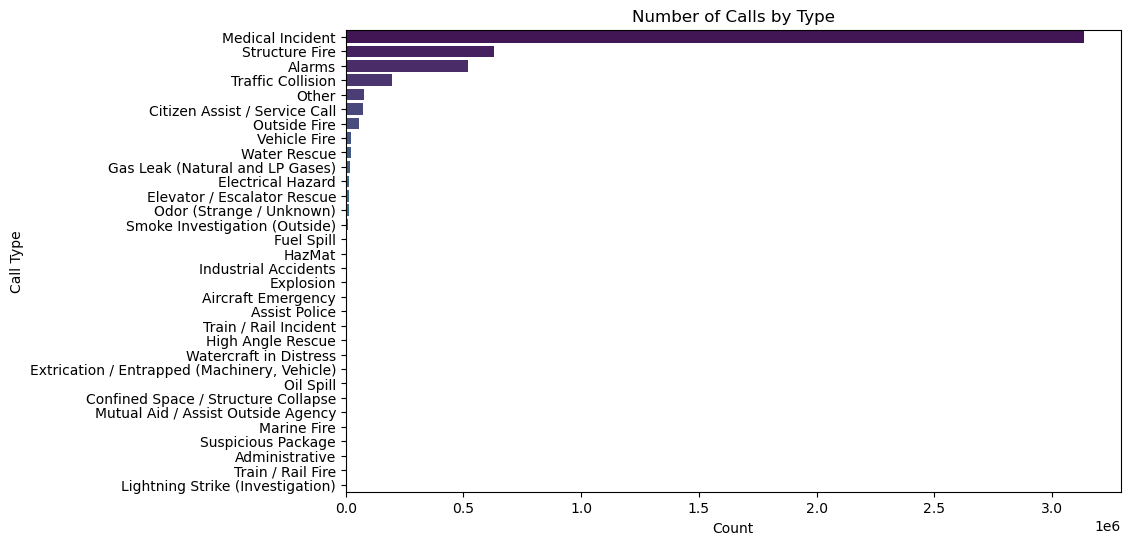

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

calltype_counts = (
    fire_ts_df
    .select("CallType")
    .where(col("CallType").isNotNull())
    .groupBy("CallType")
    .count()
    .orderBy("count", ascending=False)
)

pdf = calltype_counts.toPandas()


plt.figure(figsize=(10,6))
sns.barplot(data=pdf, x="count", y="CallType", palette="viridis")
plt.title("Number of Calls by Type")
plt.xlabel("Count")
plt.ylabel("Call Type")
plt.show()

#### Q-4a) What zip codes accounted for most common calls?

Let's investigate what zip codes in San Francisco accounted for most fire calls and what type where they.

1. Filter out by CallType
2. Group them by CallType and Zip code
3. Count them and display them in descending order

It seems like the most common calls were all related to Medical Incident, and the two zip codes are 94102 and 94103.

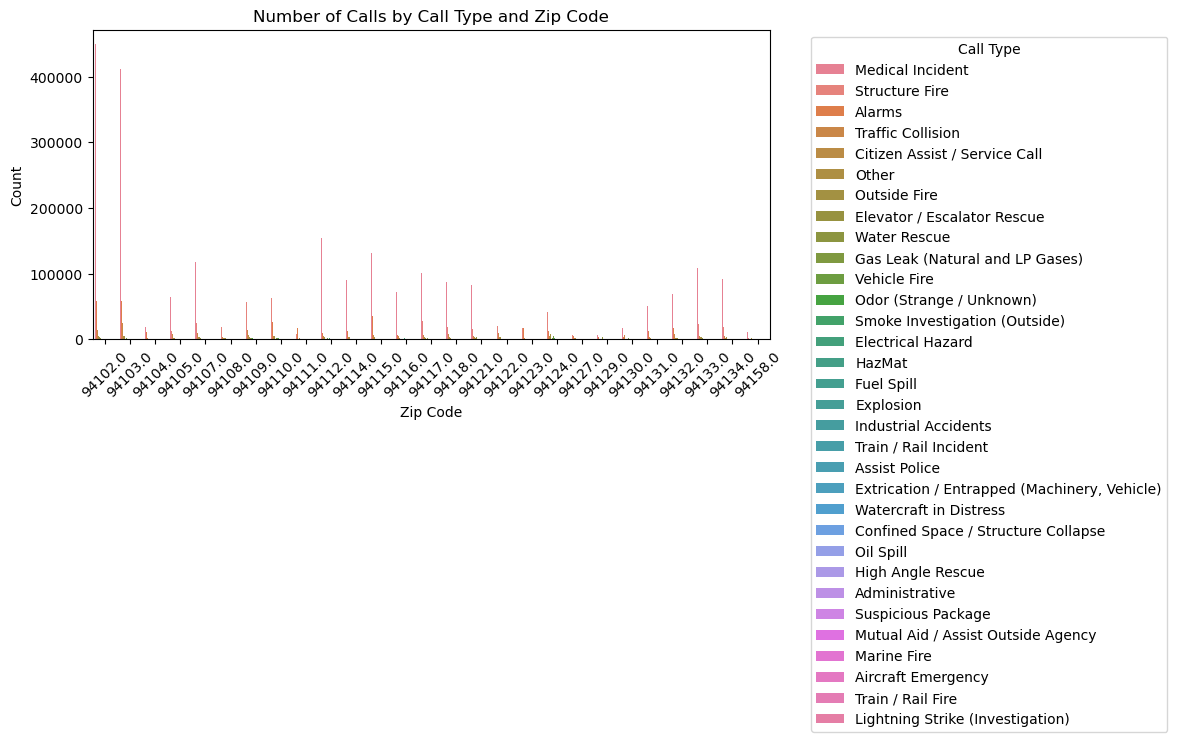

In [18]:
# Aggregate like in Databricks
calltype_zip_counts = (
    fire_ts_df
    .select("CallType", "ZipCode")
    .where(col("CallType").isNotNull())
    .groupBy("CallType", "ZipCode")
    .count()
    .orderBy("count", ascending=False)
)

# Convert to Pandas for plotting
pdf = calltype_zip_counts.toPandas()

# Plot with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    data=pdf,
    x="ZipCode",
    y="count",
    hue="CallType",
    dodge=True
)
plt.title("Number of Calls by Call Type and Zip Code")
plt.xlabel("Zip Code")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Call Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Q-4b) What San Francisco neighborhoods are in the zip codes 94102 and 94103

Let's find out the neighborhoods associated with these two zip codes. In all likelihood, these are some of the contested neighborhood with high reported crimes.

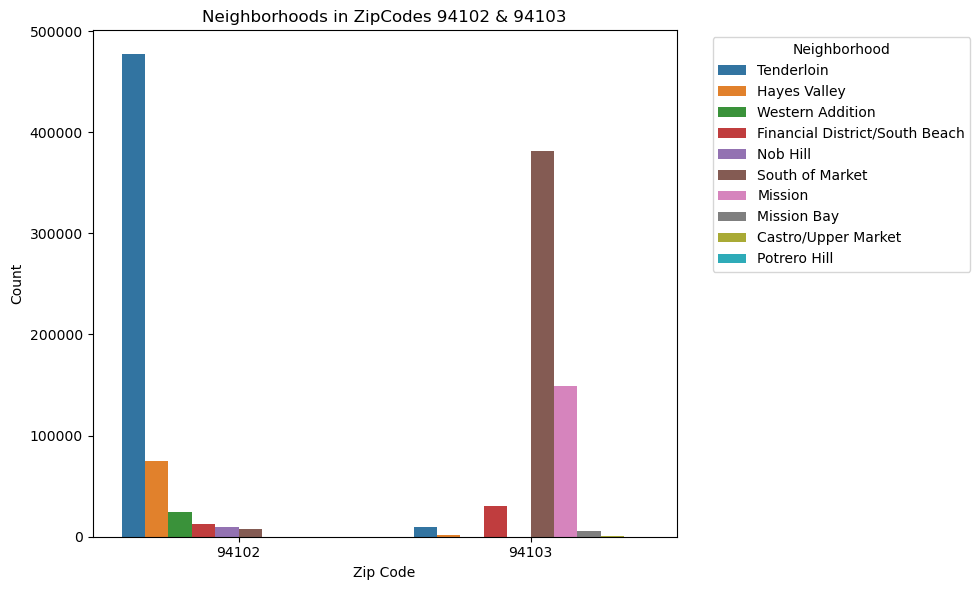

In [22]:
neighborhood_counts = (
    fire_ts_df
    .select("Neighborhood", "ZipCode")
    .where((col("ZipCode") == 94102) | (col("ZipCode") == 94103))
    .groupBy("Neighborhood", "ZipCode")
    .count()
    .orderBy("count", ascending=False)
)

pdf = neighborhood_counts.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(
    data=pdf,
    x="ZipCode",
    y="count",
    hue="Neighborhood",
    dodge=True
)
plt.title("Neighborhoods in ZipCodes 94102 & 94103")
plt.xlabel("Zip Code")
plt.ylabel("Count")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Q-5) What was the sum of all calls, average, min and max of the response times for calls?

Let's use the built-in Spark SQL functions to compute the sum, avg, min, and max of few columns:

Number of Total Alarms, avg, min, max.

In [13]:
fire_ts_df.select(sum("NumberOfAlarms"), avg("NumberOfAlarms"), min("NumberOfAlarms"), max("NumberOfAlarms")).show()

+-------------------+-------------------+-------------------+-------------------+
|sum(NumberOfAlarms)|avg(NumberOfAlarms)|min(NumberOfAlarms)|max(NumberOfAlarms)|
+-------------------+-------------------+-------------------+-------------------+
|            4851116| 1.0056383640099944|                  1|                  5|
+-------------------+-------------------+-------------------+-------------------+



#### Q-6a) How many distinct years of data is in the CSV file?

We can use the year() SQL Spark function off the Timestamp column data type IncidentDate.

In all, we have fire calls from years 2000-2018

In [14]:
fire_ts_df.select(year('IncidentDate')).distinct().orderBy(year('IncidentDate')).show()

+------------------+
|year(IncidentDate)|
+------------------+
|              2000|
|              2001|
|              2002|
|              2003|
|              2004|
|              2005|
|              2006|
|              2007|
|              2008|
|              2009|
|              2010|
|              2011|
|              2012|
|              2013|
|              2014|
|              2015|
|              2016|
|              2017|
|              2018|
+------------------+



#### Q-6b) What week of the year in 2018 had the most fire calls?

Note: Week 1 is the New Years' week and week 25 is the July 4 the week. Loads of fireworks, so it makes sense the higher number of calls.

In [15]:
fire_ts_df.filter(year('IncidentDate') == 2018).groupBy(weekofyear('IncidentDate')).count().orderBy('count', ascending=False).show()

+------------------------+-----+
|weekofyear(IncidentDate)|count|
+------------------------+-----+
|                       1| 6626|
|                      25| 6425|
|                      22| 6328|
|                      13| 6321|
|                      27| 6289|
|                      40| 6252|
|                      44| 6250|
|                      16| 6217|
|                      46| 6209|
|                      43| 6200|
|                       5| 6160|
|                      18| 6152|
|                      48| 6142|
|                       2| 6109|
|                       9| 6079|
|                      21| 6073|
|                      45| 6050|
|                       6| 6025|
|                       8| 6014|
|                      23| 5997|
+------------------------+-----+
only showing top 20 rows



#### Q-7) What neighborhoods in San Francisco had alarms in 2018?

In [17]:
fire_ts_df.select("Neighborhood", "NumberOfAlarms").filter(year("IncidentDate") == 2018).show(10, False)

+---------------------+--------------+
|Neighborhood         |NumberOfAlarms|
+---------------------+--------------+
|Bayview Hunters Point|1             |
|Tenderloin           |1             |
|Tenderloin           |1             |
|South of Market      |1             |
|Pacific Heights      |1             |
|Pacific Heights      |1             |
|Mission Bay          |1             |
|Nob Hill             |1             |
|Nob Hill             |1             |
|Tenderloin           |1             |
+---------------------+--------------+
only showing top 10 rows



#### Q-8a) How can we use Parquet files or SQL table to store data and read it back?

In [ ]:
#collapsing partitions with 'coalesce(10)' to avoid JVM memory crash, because fire_ts_df is large.

fire_ts_df.coalesce(10).write.mode("overwrite").parquet("/opt/workspace/media/fireServiceParquet")

#### Q-8b) How can read data from Parquet file?

Note we don't have to specify the schema here since it's stored as part of the Parquet metadata

In [8]:
file_parquet_df = spark.read.format("parquet").load("/opt/workspace/media/fireServiceParquet/")
file_parquet_df.show(5, truncate=False)

+----------+------+--------------+----------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+--------------------+----------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+------------+--------------------------+----------------------+------------------+------------------------------+-------------------------------------+-------------+-----+-------------------+-------------------+-------------------+
|CallNumber|UnitID|IncidentNumber|CallType        |ReceivedDtTm          |EntryDtTm             |DispatchDtTm          |ResponseDtTm          |OnSceneDtTm           |TransportDtTm         |HospitalDtTm          |CallFinalDisposition|Address               |City|Zipcode|Battalion|StationArea|Box |OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumberOfAlarms|UnitType    |UnitSeque